In [1]:
# Code from: https://github.com/gokriznastic/HybridSN
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

import numba
from numba import jit

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

import mypackage

TensorFlow version is 2.1.0


# Data Loading

In [3]:
## GLOBAL VARIABLES
dataset = 'HyperChicken'
test_ratio = 0.3
windowSize = 25

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'HyperChicken':
        print("loding stuff")
        data, labels, info = mypackage.Dataset.load("../../data/tomra")
        labels -= 1
        data, labels = data[0], labels[0]
#         data, labels = data[18:-18, 18:-18], labels[18:-18, 18:-18]
    
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=5):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = X #padWithZeros(X, margin=margin)
    # split patches
    numb_patches = (X.shape[0] - 2*margin) * (X.shape[1] - 2*margin) # TODO: Check for correctness
    patchesData = np.zeros((numb_patches, windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((numb_patches))
    patchIndex = 0
    for r in range(margin, X.shape[0] - margin):
        for c in range(margin, X.shape[1] - margin):
            patch = X[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return patchesData, patchesLabels

In [9]:
# This is code from the original Patch-Code: https://github.com/KonstantinosF/Classification-of-Hyperspectral-Image/blob/master/CreatetheDatasets.ipynb
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
X, y = loadData(dataset)

X.shape, y.shape

loding stuff


((100, 100, 208), (100, 100, 1))

In [11]:
np.unique(y)

array([0, 1, 2], dtype=int32)

In [12]:
K = X.shape[2]

In [13]:
K = 30 # if dataset == 'HyperChicken' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(100, 100, 30)

In [14]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((5776, 25, 25, 30), (5776,))

In [15]:
np.unique(y)

array([0., 1., 2.])

In [16]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((4043, 25, 25, 30), (1733, 25, 25, 30), (4043,), (1733,))

In [17]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((2695, 25, 25, 30), (1348, 25, 25, 30), (2695,), (1348,))

# Model and Training

In [18]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2695, 25, 25, 30, 1)

In [24]:
print(f"Train:\n\t{np.unique(ytrain, return_counts=True)}\nTest:\n\t{np.unique(yvalid, return_counts=True)}")

Train:
	(array([0., 1., 2.]), array([2115,  529,   51]))
Test:
	(array([0., 1., 2.]), array([1057,  265,   26]))


In [18]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(4043, 3)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [19]:
S = windowSize
L = K
output_units = 3 # if dataset == 'HyperChicken'

In [20]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
# ################ Added by me ##########################################################
# # The last dimensions in the kernel_sizes was 7, 5 and 3 is now 16, 10, 5
# # The filters was 8, 16, 32 and is now 
# conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
# conv_layer3 = conv_layer4
# #######################################################################################
print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [21]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

In [23]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
Xtrain.shape, ytrain.shape

((4043, 25, 25, 30, 1), (4043, 3))

In [26]:
# import matplotlib.pyplot as plt
# plt.imshow(ytrain[0])

In [27]:
# Had batch_size=256
history = model.fit(x=Xtrain, y=ytrain, batch_size=10, epochs=30, callbacks=callbacks_list)

Epoch 1/30
4043/4043 [==============================] - 117s 29ms/step - loss: 0.3053 - accuracy: 0.8892

Epoch 00001: accuracy improved from -inf to 0.88919, saving model to best-model.hdf5
Epoch 2/30
4043/4043 [==============================] - 114s 28ms/step - loss: 0.1799 - accuracy: 0.9396

Epoch 00002: accuracy improved from 0.88919 to 0.93965, saving model to best-model.hdf5
Epoch 3/30
4043/4043 [==============================] - 114s 28ms/step - loss: 0.1167 - accuracy: 0.9575

Epoch 00003: accuracy improved from 0.93965 to 0.95746, saving model to best-model.hdf5
Epoch 4/30
4043/4043 [==============================] - 114s 28ms/step - loss: 0.0861 - accuracy: 0.9676

Epoch 00004: accuracy improved from 0.95746 to 0.96760, saving model to best-model.hdf5
Epoch 5/30
4043/4043 [==============================] - 114s 28ms/step - loss: 0.0751 - accuracy: 0.9758

Epoch 00005: accuracy improved from 0.96760 to 0.97576, saving model to best-model.hdf5
Epoch 6/30
4043/4043 [===========

plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [28]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [29]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1733, 25, 25, 30, 1)

In [30]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(1733, 3)

In [31]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1360
           1       0.95      0.95      0.95       340
           2       0.74      0.79      0.76        33

    accuracy                           0.98      1733
   macro avg       0.90      0.91      0.90      1733
weighted avg       0.98      0.98      0.98      1733



In [32]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [33]:
def reports (X_test,y_test,name):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    if name == 'HyperChicken':
        target_names = ['Belt','Meat','Plastic']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [34]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

1733/1733 [==============================] - 9s 5ms/step


In [35]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [36]:
# load the original image
X, y = loadData(dataset)

loding stuff


In [37]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [41]:
 30 # if dataset == 'HyperChicken' else 15
# X,pca = applyPCA(X,numComponents=K)

X.shape

(100, 100, 30)

In [39]:
# X = padWithZeros(X, PATCH_SIZE//2)

In [106]:
PATCH_SIZE

25

In [107]:
# calculate the predicted image
outputs = np.zeros((height,width))

# This for-loop needs to be move to a function inorder to optimize with numba
# @jit(nopython=True, parallel=True)
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :           # TODO: What is this? And why is this?
            continue
        else :
            image_patch=Patch(X,i,j)
            n, m, k = image_patch.shape
            if image_patch.shape[0] == PATCH_SIZE and image_patch.shape[1] == PATCH_SIZE:
                X_test_image = image_patch.reshape(1, n, m, k, 1).astype('float32')
                prediction = (model.predict(X_test_image))
                prediction = np.argmax(prediction, axis=1)
                outputs[i][j] = prediction+1
            else:
                # new_patch = np.zeros((PATCH_SIZE, PATCH_SIZE, K))
                # TODO: Make this better
                prediction = -1                                
                outputs[i][j] = prediction


(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

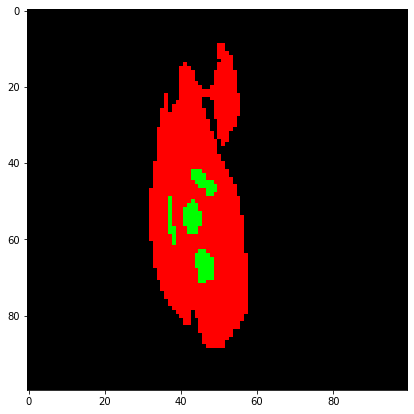

In [108]:
ground_truth = spectral.imshow(classes = np.squeeze(y),figsize =(7,7))

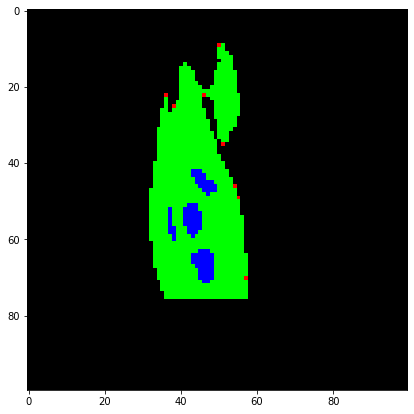

In [109]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [114]:
np.unique(outputs, return_counts=True)

(array([-1.,  0.,  1.,  2.,  3.]), array([ 169, 8587,    8, 1125,  111]))

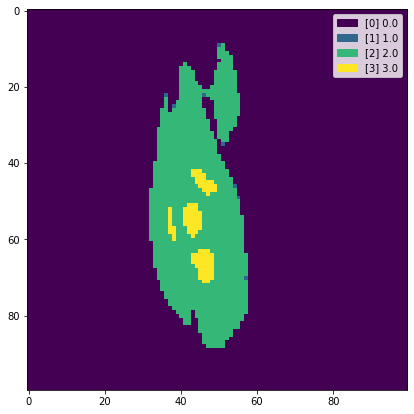

In [116]:
fixed_outputs = outputs.copy()
fixed_outputs[outputs == -1] = 2
plt.figure(figsize=(7,7))
img = plt.imshow(fixed_outputs)
mypackage.Dataset._Dataset__add_legend_to_image(fixed_outputs, img)
plt.show()

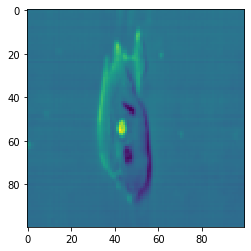

In [110]:
plt.figure()
plt.imshow(X[:, :, 1])

In [117]:
spectral.save_rgb("prediction_Stuff.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)